# Statements

- Solvers are amazing
- If we can use hand-reading / pokertracker to estimate people's ranges on the river, we can solve river strategies for all possible scenarios, both exploitative and GTO solutions

- Exploitative only depends on their range
- GTO is harder and depends on both their and our range

# Questions

- How close to GTO are people playing the river? What are the main types of mistakes that they are making? Are bettors value heavy/bluff heavy, are callers overcalling/overfolding? By how much?
- How much value do we give up by playing GTO?
- What is the relationship between exploitative and GTO strategies?

- Can we ballpark exploitative and GTO frequencies in our head?
- Problems with [0,1] GTO model
- Why do solvers call down a lot less than MDF? merged vs polarized

- hand histories

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

%matplotlib inline

plt.style.use('paper')

In [9]:
def von_neumann_I_bet(x, alpha, c):
    try:
        bet = np.zeros(len(x))
        bet[x<=c] = 1.*c - alpha*(1-c)
        bet[x>c] = 1.*c + (x[x>c]-c)*(1.+alpha) - (1.-x[x>c])*alpha
    except:
        return 1.*c - alpha*(1-c) if x <= c else 1.*c + (x-c)*(1.+alpha) - (1.-x)*alpha
    return bet

def von_neumann_I_check(x, alpha, c):
    return x

def von_neumann_exploitative_I(x, alpha, c):
    return max(von_neumann_I_bet(x, alpha, c), von_neumann_I_check(x, alpha, c))

def gtostrat(B):
    B *= 2 # ferguson uses pot size of 2, we want Pot =  1
    a= B/(B+1)/(B+4)
    b = (B**2 + 4*B + 2)/(B+1)/(B+4)
    c = B*(B+3)/(B+1)/(B+4)
    return a, b, c

def gtoval(B):
    a,b,c = gtostrat(B)
    
    # These are my calculations assuming pot = 1
    valbluff = a**2/2
    valvalue = B*(1-b)**2
    
    B*=2
    val = B/(B+1)/(B+4)/2 # from ferguson assuming pot = 2, so normalize to pot
    
    return val, valbluff, valvalue

In [10]:
def plotstrat(a, b, c):
    height=1
    fig, ax = plt.subplots()

    bluff = 'b'
    value = 'orange'
    check = 'gray'
    call = 'g'
    fold = 'r'

    p1y =  2

    ax.barh(p1y, a, height=height, color=bluff, label='Bluff')
    ax.barh(p1y, b-a, height=height, left=a, color=check, label='Check')
    ax.barh(p1y, 1-b, height=height, left=b, color=value, label='Value')

    p2y =  0
    ax.barh(p2y, c, height=height, color=fold, label='Fold')
    ax.barh(p2y, 1-c, height=height, left=c, color=call, label='Call')

    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    ax.set_ylim([-height,3*height])
    ax.set_xlim([0,1])

    ax.text(-0.2, p1y, 'P1', fontsize=20)
    ax.text(-0.2, p2y, 'P2', fontsize=20)
    ax.text(b-0.02, p1y+height*2/3, 'b', fontsize=20)
    ax.text(a-0.02, p1y+height*2/3, 'a', fontsize=20)
    ax.text(c-0.02, p2y+height*2/3, 'c', fontsize=20)
    ax.legend(loc=(1.1, 0.2))
    return fig

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


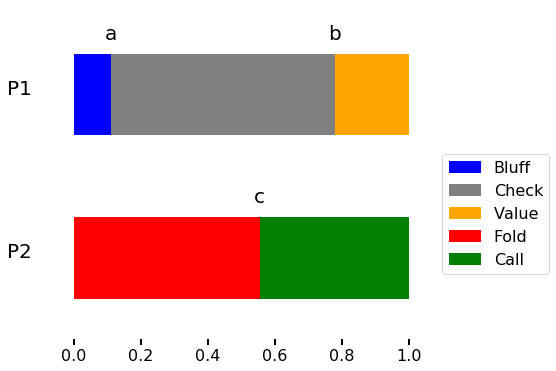

In [11]:
a,b,c = gtostrat(B=1)
fig = plotstrat(a,b,c)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


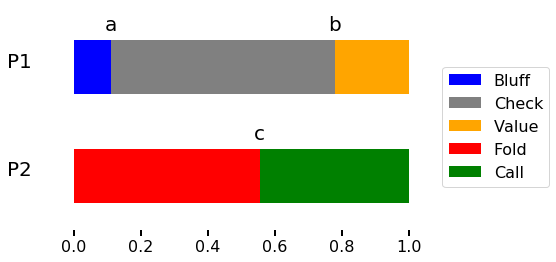

In [7]:
fig = plotstrat(a=1/9, b=7/9, c=5/9)

In [4]:
alpha = 1
c = 0.7
riverpotsize = 25

allbetvalue = quad(von_neumann_I_bet, 0, 1, args=(alpha, c))[0]-0.5
maxexploitvalue = quad(von_neumann_exploitative_I, 0, 1, args=(alpha, c))[0]-0.5
print('100%bet value = {0:.2f} BB/100'.format(allbetvalue*riverpotsize*100), 'Max Exploit value = {0:.2f} BB/100'.format(maxexploitvalue*riverpotsize*100), 'Difference = {0:.2f} BB/100'.format((maxexploitvalue-allbetvalue)*riverpotsize*100))

100%bet value = 87.50 BB/100 Max Exploit value = 256.25 BB/100 Difference = 168.75 BB/100


In [5]:
def f(c, alpha):
    fig, ax = plt.subplots()
    Nout = 1000
    x = np.linspace(0, 1, Nout)
    bet = von_neumann_I_bet(x, alpha, c)
    check = von_neumann_I_check(x, alpha, c)
    val = quad(von_neumann_exploitative_I, 0, 1, args=(alpha, c))[0]-0.5 # 0.5 = ante
    ax.plot(x, check, 'g', label='check')
    ax.plot(x, bet, 'r', label='bet')
    ax.set_xlim([0,1])
    ymax = ax.get_ylim()[1]
    ax.text(0.4, 0.8*ymax, "val={0:0.3f}".format(val), fontsize=16)
    ax.legend()
    ax.set_xlabel("Player I x")
    ax.set_ylabel("Value")

Specify c and alpha, then maximally exploitive strategy is the max of the check and bet lines

In [6]:
interactive_plot = interactive(f, c=widgets.FloatSlider(min=0.0, max=1., step=0.02, value=0.6), alpha=widgets.FloatSlider(min=0, max=2., step=0.1, value=1.))
interactive_plot

interactive(children=(FloatSlider(value=0.6, description='c', max=1.0, step=0.02), FloatSlider(value=1.0, desc…

should be able to extend floatrangeslider to make multiple  sliders on same range

In [9]:
B = np.linspace(0, 5, 100)
val, valbluff, valvalue = gtoval(B)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


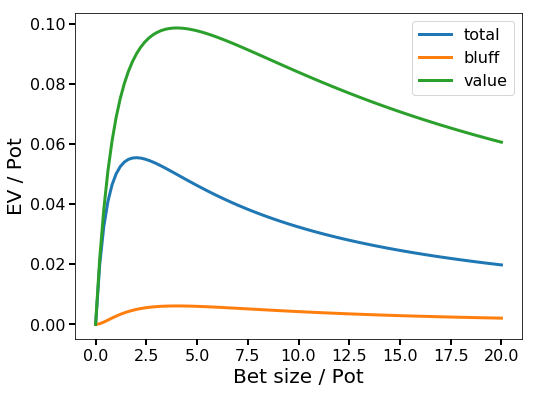

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(B, val, label='total')
ax.plot(B, valbluff, label='bluff')
ax.plot(B, valvalue, label='value')
ax.set_xlabel('Bet size / Pot')
ax.set_ylabel('EV / Pot')
ax.legend()

In [11]:
def fgto(B):
    a,b,c = gtostrat(B)
    
    fig, ax = plt.subplots()
    Nout = 1000
    x = np.linspace(0, 1, Nout)
    bet = von_neumann_I_bet(x, B, c)
    check = von_neumann_I_check(x, B, c)
    val = quad(von_neumann_exploitative_I, 0, 1, args=(B, c))[0]-0.5 # 0.5 = ante
    ax.plot(x, check, 'g', label='check')
    ax.plot(x, bet, 'r', label='bet')
    ax.set_xlim([0,1])
    ymax = ax.get_ylim()[1]
    ax.text(0.4, 0.8*ymax, "val={0:0.3f}".format(val), fontsize=16)
    ax.legend()
    ax.set_xlabel("Player I x")
    ax.set_ylabel("Value")

In [12]:
interactive_plot = interactive(fgto, B=widgets.FloatSlider(min=0, max=5., step=0.1, value=1.))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='B', max=5.0), Output()), _dom_classes=('widget-inter…

a=0.111, b=0.778,c=0.556


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


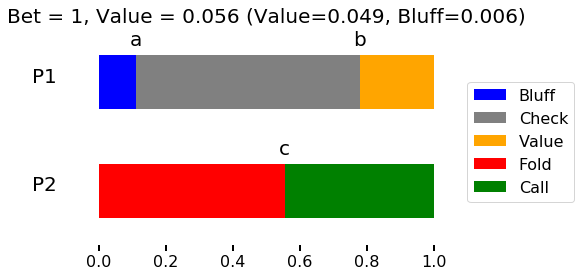

In [14]:
B=1
fig = plotstrat(B)

a=0.065, b=0.922,c=0.844


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


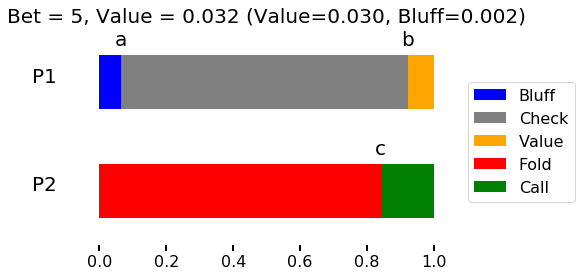

In [15]:
B=5
fig = plotstrat(B)

a=0.082, b=0.647,c=0.293


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


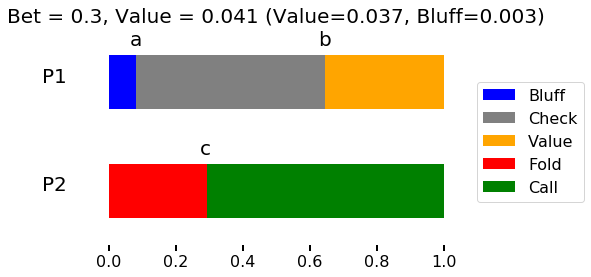

In [16]:
B=0.3
fig = plotstrat(B)

a=0.100, b=0.700,c=0.400


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


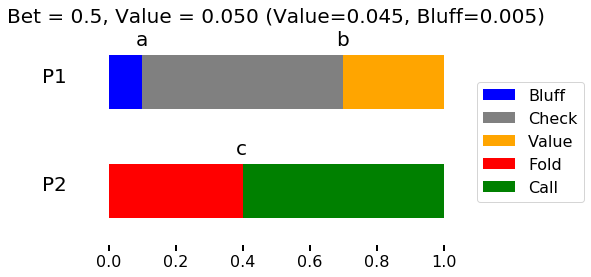

In [17]:
B=0.5
fig = plotstrat(B)

In [18]:
AT+

SyntaxError: invalid syntax (<ipython-input-18-5c0aa590423e>, line 1)

In [ ]:
32 / 114

Board: As7h4c2d2h
# No Removal

Range: TT-88, AJs-A8s, A6s-A5s, A3s-A2s, 97s, 87s, 75s+, AJo-A8o = 114 combos
Call Range: AT+ = 32 combos
    
VBet AJ = 16 combos
Check A8-AT = 32+16
Bluff Rest = 

# Board Removal

Range: TT-88, AJs-A8s, A6s-A5s, A3s-A2s, 97s, 87s, 75s+, AJo-A8o = 88 combos
Call Range: AT+ = 24 combos
    
VBet AJ = 12 combos
Check A8-AT = 24+12
Bluff Rest = 40

In [ ]:
In BTN betting range 430 combos bet out of 457

In [ ]:
430/457

# How big a mistake to check A3?

With board and hand blockers, 68 combos, of which 36 beat you and 2 tie, and 16 call
Combos that beat you

In [ ]:
36/68

In [ ]:
EVx = 32/68*1 + 2/68*0.5
EVx

In [ ]:
EVb = 1*52/68 - 1*16/68
EVb

Mistake of checking A3 rather than turning into a bluff in BB/100? Assume 10 BB river pot

Mistake of checking A3 rather than turning into a bluff

In [ ]:
(EVb-EVx)*10*100

In [ ]:
Mistake of checking 88, 75 combos with removal, 63 beat you, 1 ties, 16 call

In [ ]:
EVx = 11/75*1 + 1/75*0.5
EVx

In [ ]:
EVb = 1*43/75 - 1*32/75
EVb

In [ ]:
32/75

In [ ]:
(EVb-EVx)*10*100a

Check in PT4 what fraction of hands get to river in single raised pots

6744 reached river out of 17393 saw flop out of 78445 hands

In [ ]:
17393/78445

In [ ]:
6744/17393

In [ ]:
6744/78445

8.5% of total hands see river, 22% see flop, 40% of those that see flop see river

In [ ]:
Do Pando with wider flop calling range down to A2o, and make mistake bigger

In [ ]:
Range: TT-88, 66-55, 33, AQs-A8s, A6s-A5s, A3s, K7s, K4s, Q7s, Q4s, J7s, J4s, T7s, T4s, 97s, 94s, 84s+, 75s+, 73s, 63s+, 53s+, 43s, AQo-A8o, A6o-A5o, A3o
= 206 combos
Call Range: Any A: 96 combos
Vbet: 48 = A9+
Bluff: 14 combos = 35s, 46s, 56s, 58s